In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [58]:
events = np.loadtxt("../tum-vie/events_005_refact_0001.txt")

In [59]:
def filter_patch(events, patch_center, patch_size):
    x_lim = (patch_center[1] - int(patch_size / 2), patch_center[1] + int(patch_size / 2) - 1)
    y_lim = (patch_center[0] - int(patch_size / 2), patch_center[0] + int(patch_size / 2) - 1)

    events_filtered = np.copy(events)
    events_filtered = events_filtered[
        np.logical_and((x_lim[0] <= events_filtered[:, 1]), (events_filtered[:, 1] <= x_lim[1]))]
    events_filtered = events_filtered[
        np.logical_and((y_lim[0] <= events_filtered[:, 2]), (events_filtered[:, 2] <= y_lim[1]))]
    # events_filtered = events_filtered[[(y_lim[0] >= events_range[:,2]) & (events_range[:,2] <= y_lim[1])]
    #vents_filtered = np.array(events_filtered)

    events_filtered[:,1] = (events_filtered[:,1] - patch_center[1] + int(patch_size / 2)).astype(int)
    events_filtered[:,2] = (events_filtered[:,2] - patch_center[0] + int(patch_size / 2)).astype(int)
    
    return events_filtered

In [60]:
patch_center = (360, 640)
patch_size = 720
shape = (patch_size, patch_size)
events = filter_patch(events, patch_center, patch_size)

In [61]:
events[:,0] *= 1e-6

In [62]:
events = events[10000:,:]

# With conv

In [63]:
conv_shape = (3, 3)
conv_stride = (3, 3)
thresh = 0.5
result_shape = (int(shape[0]/conv_stride[0]), int(shape[1]/conv_stride[1]))
conv_acc = np.zeros(result_shape)
event_conv = []
for e in events:
    if e[3] == 1:
        continue
    
    x = int(e[1] / conv_stride[0])
    y = int(e[2] / conv_stride[1])
    
    conv_acc[y, x] += 1
    
    if conv_acc[y, x] >= conv_shape[0]*conv_shape[1] * thresh:
        event_conv.append([e[0], x, y, e[3]])
        
event_conv = np.array(event_conv)

In [64]:
last_time = np.zeros(result_shape)
time_difference = np.zeros(result_shape)
dist = 5
for e in event_conv:
    if e[3] == 1:
        continue
            
    x = int(e[1])
    y = int(e[2])
    
    last_time[y, x] = e[0]
    
    if x >= result_shape[1] - dist -1:
        continue
    if last_time[y, x+dist] != 0:
        time_difference[y, x] = e[0] - last_time[y, x+dist]

In [65]:
conv_shape = (3, 3)
conv_stride = (3, 3)
result_shape = (int(result_shape[0]/conv_stride[0]), int(result_shape[1]/conv_stride[1]))
dict_px = {} 
for x in range(time_difference.shape[1]):
    for y in range(time_difference.shape[0]):
        if time_difference[y, x] == 0:
            continue

        x_c = int(x / conv_stride[0])
        y_c = int(y / conv_stride[1])

        if (y_c, x_c) in dict_px:
            dict_px[y_c, x_c].append(time_difference[y, x])
        else:
            dict_px[y_c, x_c] = [time_difference[y, x]]

In [66]:
time_diff_med = np.zeros(result_shape)
for k in dict_px:
    y = k[0]
    x = k[1]
    if len(dict_px[k]) <= 5:
        continue
    time_diff_med[y, x] = np.median(dict_px[k])

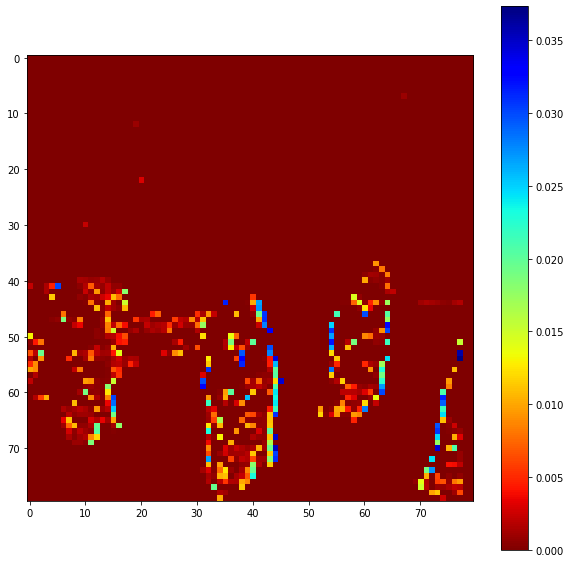

In [67]:
%matplotlib inline
plt.figure(figsize=(10, 10))
m = plt.imshow(time_diff_med, cmap="jet_r")
plt.colorbar(mappable=m)

In [68]:
time_diff_med_m = np.ma.masked_where(time_diff_med<=0, time_diff_med)
u = np.divide(1, time_diff_med_m, where=time_diff_med > 0)

In [69]:
v = 0.00184

In [70]:
f = 1049.048422241493

In [71]:
d = np.divide(f, u, where=u>0.0) * v

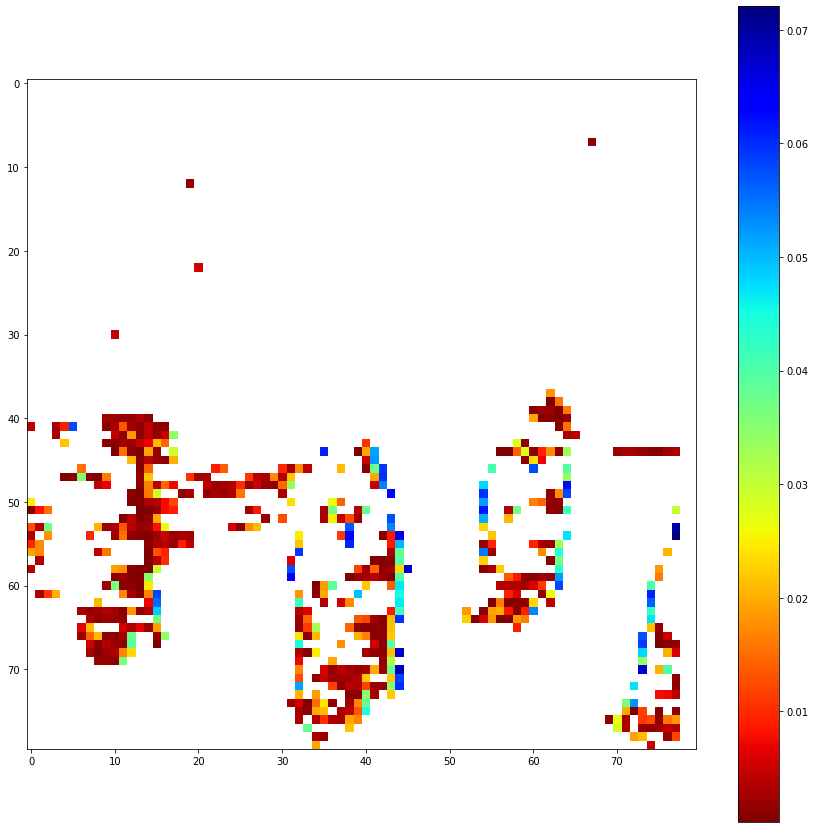

In [72]:
plt.figure(figsize=(15, 15))
m = plt.imshow(d, cmap="jet_r")
plt.colorbar(m)

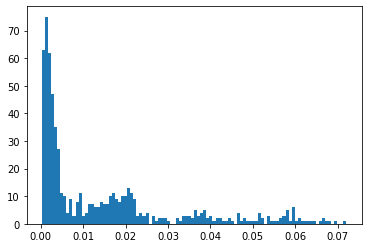

In [73]:
plt.hist(d.compressed(), 100);

In [74]:
points = []
for x in range(d.shape[1]):
    for y in range(d.shape[0]):
        if d.mask[y, x] or d.data[y, x] > 0.04:
            continue
        points.append([x, y, d.data[y, x]])
points = np.array(points)

In [75]:
%matplotlib qt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2],s=20, c=points[:,2], cmap="jet_r")
#ax.set_zlim3d([0, 0.02])
plt.show()

# Without conv

In [76]:
last_time = np.zeros(shape)
time_difference = np.zeros(shape)
dist = 5
for e in events:
    if e[3] == 1:
        continue
            
    x = int(e[1])
    y = int(e[2])
    
    last_time[y, x] = e[0]
    
    if x >= shape[1] - dist -1:
        continue
    if last_time[y, x+dist] != 0:
        time_difference[y, x] = e[0] - last_time[y, x+dist]

In [77]:
conv_shape = (5, 5)
conv_stride = (5, 5)
result_shape = (int(shape[0]/conv_stride[0]), int(shape[1]/conv_stride[1]))
dict_px = {} 
for x in range(time_difference.shape[1]):
    for y in range(time_difference.shape[0]):
        if time_difference[y, x] == 0:
            continue

        x_c = int(x / conv_stride[0])
        y_c = int(y / conv_stride[1])

        if (y_c, x_c) in dict_px:
            dict_px[y_c, x_c].append(time_difference[y, x])
        else:
            dict_px[y_c, x_c] = [time_difference[y, x]]

In [78]:
time_diff_med = np.zeros(result_shape)
for k in dict_px:
    y = k[0]
    x = k[1]
    if len(dict_px[k]) <= 3:
        continue
    time_diff_med[y, x] = np.median(dict_px[k])

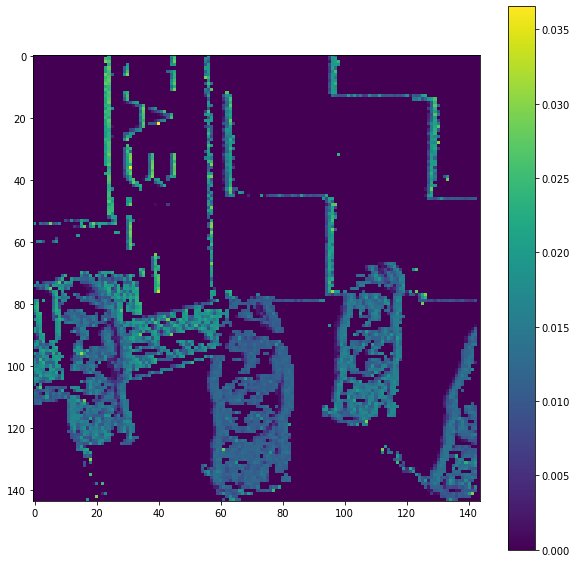

In [79]:
%matplotlib inline
plt.figure(figsize=(10, 10))
m = plt.imshow(time_diff_med)
plt.colorbar(mappable=m)

In [80]:
time_diff_med_m = np.ma.masked_where(time_diff_med<=0, time_diff_med)
u = np.divide(1, time_diff_med_m, where=time_diff_med > 0)
v = 0.00184
f = 1049.048422241493
d = np.divide(f, u, where=u>0.0) * v

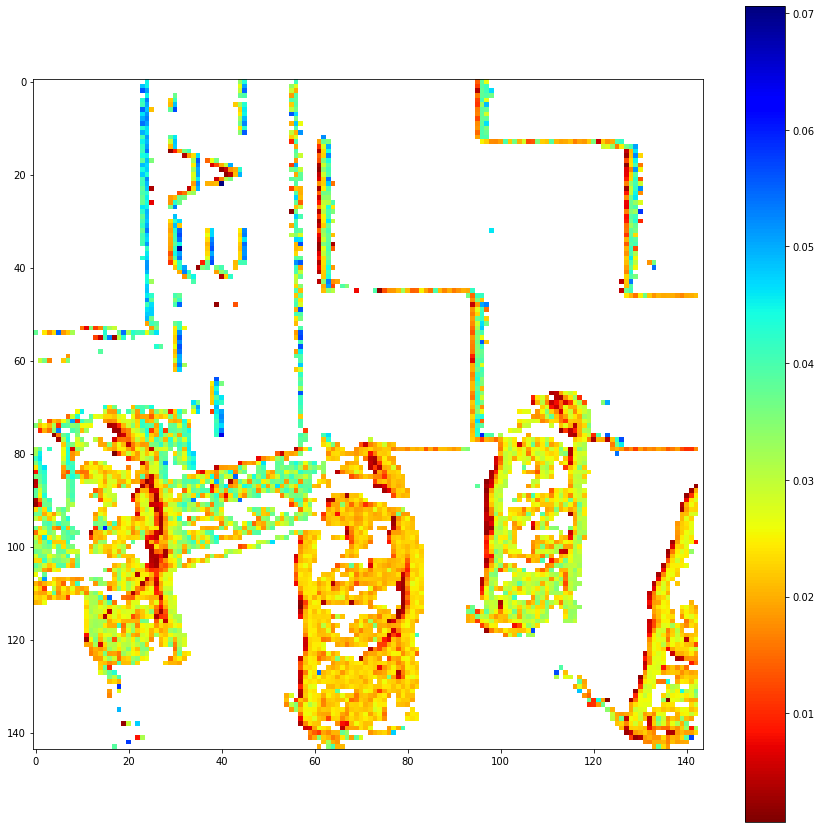

In [81]:
plt.figure(figsize=(15, 15))
m = plt.imshow(d, cmap="jet_r")
plt.colorbar(m)

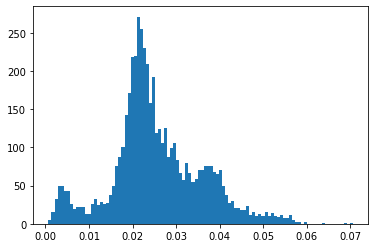

In [82]:
plt.hist(d.compressed(), 100);

In [83]:
points = []
for x in range(d.shape[1]):
    for y in range(d.shape[0]):
        if d.mask[y, x]:
            continue
        points.append([x, y, d.data[y, x]])
points = np.array(points)

In [84]:
# points[:,2] = np.digitize(points[:,2], np.linspace(points[:,2].min(), points[:,2].max(), 10))

In [85]:
%matplotlib qt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2],s=10, c=points[:,2])
#ax.set_zlim3d([0, 0.02])
plt.show()